# PRÁCTICA 2: APRENDIZAJE DE PYTORCH

### Javier Izquierdo Hernández
### Alberto León Luengo
### Eva Fernández de la Cruz

---

## Configuración de las Rutas de Importación

Se añade el directorio padre (..) al path (sys.path), lo que permite al entorno de Python acceder a módulos o paquetes ubicados en directorios superiores al actual. Esto es útil para poder importar scripts o paquetes personalizados sin tener que mover ficheros o el directorio de trabajo.

In [7]:
import sys
sys.path.insert(0, '..')

## Verificación de las Versiones de los Paquetes

Se utiliza la función check_packages() para verificar que los paquetes y sus respectivas versiones indicadas en el diccionario 'd' estén instalados correctamente dentro del entorno. Este paso es importante para verificar la compatibilidad de cada paquete para poder evitar errores por diferencia de versión.

In [8]:
from python_environment_check import check_packages
d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'mlxtend' : '0.19.0',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2',
    'torch': '1.9.0',
    'torchvision': '0.9.0',
    'tensorboard': '2.7.0',
    'pytorch_lightning': '1.5.0',
    'torchmetrics': '0.6.2'
}
check_packages(d)

[FAIL]: tensorboard is not installed and/or cannot be imported.
[OK] numpy 2.1.1
[OK] scipy 1.14.1
[OK] mlxtend 0.23.3
[OK] matplotlib 3.9.2
[OK] sklearn 1.5.2
[OK] pandas 2.2.2
[OK] torch 2.5.1+cu124
[OK] torchvision 0.20.1+cu124
[OK] pytorch_lightning 2.4.0
[OK] torchmetrics 1.6.0


## Importar librerías

In [9]:
# REDES NEURONALES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PYTORCH
import torch
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

---


## 1. Introducción
En este Notebook se abordará el problema de clasificación binaria propuesto.

Para ello, se utilizará el dataset 'Adult', obtenido del UC Irvine Machine Learning Repository. Este dataset incluye información sobre las ganancias anuales de una persona, en este caso, la variable de salida 'y' predice si una persona gana más o menos de 50000$ al año, basándose en varias características demográficas y laborales.

Y por último, se hará uso de PyTorch para implementar una red neuronal que satisfaga todo lo mencionado anteriormente.Hemos elegido este dataset debido a que contiene todo lo que necesitamos para la práctica, ya que tiene caracteríscas numéricas y categóricas.

Para poder utilizar este dataset es necesario usar one hot encoding para convertir las características categoricas a números. Debidp a errores al intentarlo con PyTorch lo hacemos a mano con pandas.

In [10]:
# Obtain the MNIST dataset
header = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

df = pd.read_csv('adult.data', names=header, header=None, sep=', ')
df_test = pd.read_csv('adult.test', names=header, header=None, skiprows=[0], sep=', ')

categorical_columns = df.loc[:, df.dtypes == 'object'].columns
numerical_columns = df.loc[:, df.dtypes == np.int64].columns

# Manual one hot encoding
for cat in categorical_columns:
  indexes = np.unique(df[cat])
  replace = {k: v for v, k in enumerate(indexes)}
  df = df.replace({cat: replace})
  df_test = df_test.replace({cat: replace})

categorical_columns = categorical_columns[:-1]

df.head(1)

/tmp/ipykernel_49229/3248847456.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('adult.data', names=header, header=None, sep=', ')
/tmp/ipykernel_49229/3248847456.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_test = pd.read_csv('adult.test', names=header, header=None, skiprows=[0], sep=', ')
/tmp/ipykernel_49229/3248847456.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0


Como se puede ver, el dataset de entrenamiento está formado por 32561 filas y 15 columnas. Cosa que nos viene bien porque tenemos muchos datos que analizar.

In [11]:
df_test.head(1)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0


El dataset de test está formado por 16281 filas y 15 columnas.

## 2. Conviertiendo el dataset a PyTorch

Divimos los datos en entrenamiento, validación y test para poder realizar el entrenamiento, quedándonos con un 80% del dataset de entrenamiento para entrenamiento y el resto para validación. Para el dataset de test nos quedamos con todo el que nos dan.

In [12]:
df_train, df_valid = train_test_split(
    df, train_size=0.8, random_state=1
)

train_stats = df_train.describe().transpose()

A continuación, normalizamos los datos de las columnas numéricas para poder utililzarlos en el entrenamiento del NN.

In [13]:
df_train_norm, df_valid_norm, df_test_norm = df_train.copy(), df_valid.copy(), df_test.copy()
for col_name in numerical_columns:
    mean = train_stats.loc[col_name, 'mean']
    std  = train_stats.loc[col_name, 'std']
    df_train_norm.loc[:, col_name] = \
        (df_train_norm.loc[:, col_name] - mean)/std
    df_valid_norm.loc[:, col_name] = \
        (df_valid_norm.loc[:, col_name] - mean)/std
    df_test_norm.loc[:, col_name] = \
        (df_test_norm.loc[:, col_name] - mean)/std
df_train_norm.tail()

/tmp/ipykernel_49229/2954724609.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.03136861  1.13088809 -0.48174048 ... -0.84824698  1.49739459
 -0.40843918]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_norm.loc[:, col_name] = \
/tmp/ipykernel_49229/2954724609.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.71729849 -1.50795867 -0.99484957 ... -0.26183658 -0.62834308
  0.9842855 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_valid_norm.loc[:, col_name] = \
/tmp/ipykernel_49229/2954724609.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.99484957 -0.04193269 -0.77494568 ... -0.04193269  0.39787511
 -0.26183658]' has dtype incompatible with int64, please ex

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
32511,-0.994850,2,3.064737,9,1.128816,4,1,3,2,0,-0.147251,-0.217988,-0.034533,39,0
5192,-0.481740,4,0.166802,9,1.128816,2,4,0,4,1,1.900268,-0.217988,0.370763,39,1
12172,-0.848247,4,-0.807308,9,1.128816,4,7,1,1,1,-0.147251,-0.217988,-0.034533,0,0
235,1.497395,7,0.742826,11,-0.422467,2,8,0,4,1,-0.147251,-0.217988,-0.034533,39,0
29733,-0.408439,4,-1.235551,9,1.128816,2,1,0,4,1,-0.147251,4.493905,0.370763,39,1


Ahora dividimos los dataset normalizados en X e y para poder entrenar la base de datos.

In [14]:
X_train = torch.tensor(df_train_norm[features].values).float()
y_train = torch.tensor(df_train_norm['income'].values).float()
X_valid = torch.tensor(df_valid_norm[features].values).float()
y_valid = torch.tensor(df_valid_norm['income'].values).float()
X_test = torch.tensor(df_test_norm[features].values).float()
y_test = torch.tensor(df_test_norm['income'].values).float()

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

torch.Size([26048, 14])
torch.Size([6513, 14])
torch.Size([16281, 14])


Por último movemos los tensores a la gpu si esta disponible y los cargamos para usarlos más adelante.

In [15]:
# Move to gpu
if torch.cuda.is_available():
  X_train = X_train.cuda()
  y_train = y_train.cuda()
  X_valid = X_valid.cuda()
  y_valid = y_valid.cuda()
  X_test = X_test.cuda()
  y_test = y_test.cuda()


# Creating the DataLoader
train_ds = TensorDataset(X_train, y_train)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_ds = TensorDataset(X_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=False)
test_ds = TensorDataset(X_test, y_test)
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

## 3. Creando la red neuronal

Se crea una red neuronal simple para clasificación binaria. Para ello, se utilizará ReLU para las activaciones internas y Sigmoid para la salida.

In [16]:
class BinaryClassifier(nn.Module):
    
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        return x

# Model initialization.
device = "cuda" if torch.cuda.is_available() else "cpu"
model = BinaryClassifier(X_train.shape[1]).to(device)
model

BinaryClassifier(
  (layer1): Linear(in_features=14, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 4. Configurando el entrenamiento de la red neuronal

Se define la función de pérdida con BCE (Binary Cross Entropy) y el optimizador, además de configurarse el ciclo de entrenamiento.

In [17]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

## 5. Entrenando la red neuronal

Ponemos las épocas para ir cómo se va entrenando, en nuestro caso, le hemos especificado que en vez de entrenarse una sóla vez, se entrene 1000 veces, para mayor precisión

Epoch 1, Loss: 0.4312
Epoch 2, Loss: 0.3762
Epoch 3, Loss: 0.3499
Epoch 4, Loss: 0.3365
Epoch 5, Loss: 0.3334
Epoch 6, Loss: 0.3307
Epoch 7, Loss: 0.3285
Epoch 8, Loss: 0.3278
Epoch 9, Loss: 0.3255
Epoch 10, Loss: 0.3257
Epoch 11, Loss: 0.3255
Epoch 12, Loss: 0.3230
Epoch 13, Loss: 0.3244
Epoch 14, Loss: 0.3228
Epoch 15, Loss: 0.3217
Epoch 16, Loss: 0.3208
Epoch 17, Loss: 0.3200
Epoch 18, Loss: 0.3212
Epoch 19, Loss: 0.3184
Epoch 20, Loss: 0.3192
Epoch 21, Loss: 0.3187
Epoch 22, Loss: 0.3178
Epoch 23, Loss: 0.3175
Epoch 24, Loss: 0.3175
Epoch 25, Loss: 0.3166
Epoch 26, Loss: 0.3166
Epoch 27, Loss: 0.3150
Epoch 28, Loss: 0.3146
Epoch 29, Loss: 0.3134
Epoch 30, Loss: 0.3137
Epoch 31, Loss: 0.3141
Epoch 32, Loss: 0.3126
Epoch 33, Loss: 0.3127
Epoch 34, Loss: 0.3118
Epoch 35, Loss: 0.3114
Epoch 36, Loss: 0.3099
Epoch 37, Loss: 0.3100
Epoch 38, Loss: 0.3092
Epoch 39, Loss: 0.3083
Epoch 40, Loss: 0.3084
Epoch 41, Loss: 0.3087
Epoch 42, Loss: 0.3072
Epoch 43, Loss: 0.3059
Epoch 44, Loss: 0.30

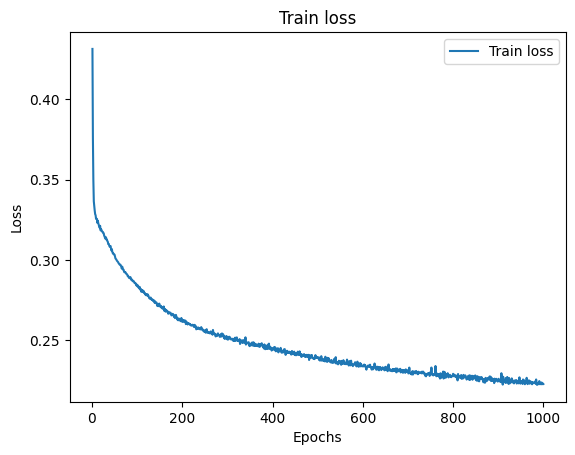

In [18]:
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    train_loss = train(model, train_dl, loss_fn, optimizer)
    train_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

plt.plot(range(1, num_epochs+1), train_losses, label='Train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train loss')
plt.legend()
plt.show()

En esta gráfica podemos visualizar la evolución del entrenamiento, que, cómo se puede ver, es satisfactorio porque reduce la pérdida casi a 0.

Una vez entrenado, podemos ver su precisión de la siguiente forma:

In [19]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in loader:
            outputs = model(X_batch).squeeze()
            predictions = (outputs > 0.5).int()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

accuracy = evaluate(model, test_dl)
print(f"Test accuracy: {accuracy * 100:.2f}%")

Test accuracy: 83.07%


Que, cómo se puede ver, es bastante buena, lo que quiere decir que el entrenamiento ha ido bien.